In [1]:
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import pandas as pd
import pm4py
import seaborn as sns

from sim.importing import prepare_input
import sim.manual_modeling as mm
import sim.petrinet_replay as repl
import sim.sim_tests
import sim.viz
import sim.whatifs as wifs
import sim.enums as enm
import sim.parameter_implementations as par_impl
from sim.simulation import simulate, create_simulation_model


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Arrivals:
default: ArrivalProcessConfig(first_arrival=2021-04-17 13:15:00+02:00, inter_arrivals=StaticSampler(1:00:00), business_hours=AlwaysInBusiness)
Activities:
A: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 50}) m), business_hours=AlwaysInBusiness)
B: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 20}) m), business_hours=AlwaysInBusiness)
C: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 40}) m), business_hours=AlwaysInBusiness)
Resources:
System: ResourceConfig(capacity=2, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
R1: ResourceConfig(capacity=1, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
R2: ResourceConfig(capacity=1, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
Decision Points: n/a
MappingConfig(assignable_resources={'A': {'System'}, 'B': {'R1'}, 'C': {'R2'}})


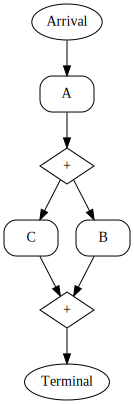

In [2]:
graph, config = sim.sim_tests.another_one()
original_log = simulate(create_simulation_model(graph, config)).get_log(enm.AvailableLifecycles.CompleteOnly)
_, net = prepare_input(original_log)
print(config)
sim.viz.visualize_sim_graph(graph, label_decision_points=True)

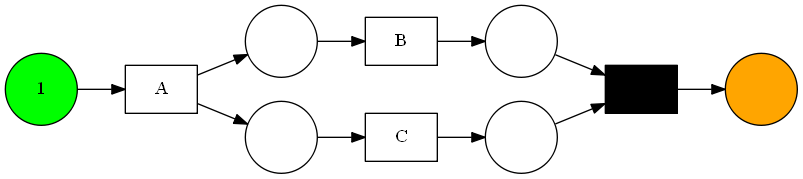

In [3]:
pm4py.view_petri_net(net.net, net.im, net.fm)

In [4]:
mb = mm.ModelBuilder(graph, config)

In [5]:
modified_graph, modified_config = mb.build()

In [6]:
print(modified_config)

Arrivals:
default: ArrivalProcessConfig(first_arrival=2021-04-17 13:15:00+02:00, inter_arrivals=StaticSampler(1:00:00), business_hours=AlwaysInBusiness)
Activities:
A: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 50}) m), business_hours=AlwaysInBusiness)
B: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 20}) m), business_hours=AlwaysInBusiness)
C: ActivityConfig(queueing_discipline=Fifo, processing_time_sampler=DistSampler(expon({'scale': 40}) m), business_hours=AlwaysInBusiness)
Resources:
System: ResourceConfig(capacity=2, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
R1: ResourceConfig(capacity=1, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
R2: ResourceConfig(capacity=1, business_hours=AlwaysInBusiness, performance=ConstantPeakPerformance)
Decision Points: n/a
MappingConfig(assignable_resources={'A': {'System'}, 'B': {'R1'}, 'C': {'R2'}})


In [7]:
execution_parameters = {enm.ExecutionParameters.SimStartDate: datetime(2021, 8, 30),
                        enm.ExecutionParameters.SimCutoffDate: datetime(2021, 9, 24),
                        enm.ExecutionParameters.CasesToGenerate: None,
                        enm.ExecutionParameters.RealtimeLimit: timedelta(seconds=30)}

In [8]:
model = create_simulation_model(graph, config, execution_parameters=execution_parameters)

what_if = wifs.ButWhatIf(model)
change_start, change_end = datetime(2021, 9, 10), datetime(2021, 9, 17)
#what_if.schedule_resource_business_hours_change(datetime(2021, 9, 10), 'R2', par_impl.StandardWorkweek)
#what_if.schedule_resource_business_hours_change(datetime(2021, 9, 17), 'R2', par_impl.AlwaysInBusiness)
what_if.schedule_activity_property_change(datetime(2021, 9, 1), 'B', enm.ActivityProperty.ProcessingTimeSampler, par_impl.ResourceDependentPTSampler(par_impl.ExpSampler(20), use_resource_performance=True))
what_if.schedule_resource_property_change(change_start, 'R1', enm.ResourceProperty.Performance, par_impl.ConstantPerformance(.25))
#what_if.schedule_resource_property_change(change_start, 'R2', enm.ResourceProperty.Capacity, 1)
what_if.schedule_resource_property_change(change_end, 'R1', enm.ResourceProperty.Performance, par_impl.PeakPerformance)
#what_if.schedule_resource_property_change(change_end, 'R2', enm.ResourceProperty.Capacity, 1)

In [9]:
what_if.apply()

In [10]:
simulation = simulate(model)

log = simulation.get_log(enm.AvailableLifecycles.CompleteOnly)

In [11]:
print(len(original_log), len(log))
print(original_log[0], log[0])

1000 597
{'attributes': {'concept:name': 'default_case_0'}, 'events': [{'concept:name': 'A', 'time:timestamp': Timestamp('2021-04-17 13:18:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'System', 'lifecycle:transition': 'complete'}, '..', {'concept:name': 'C', 'time:timestamp': Timestamp('2021-04-17 15:53:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'R2', 'lifecycle:transition': 'complete'}]} {'attributes': {'concept:name': 'default_case_1'}, 'events': [{'concept:name': 'A', 'time:timestamp': Timestamp('2021-08-30 01:23:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'System', 'lifecycle:transition': 'complete'}, '..', {'concept:name': 'C', 'time:timestamp': Timestamp('2021-08-30 01:54:00+0200', tz='Mitteleuropäische Sommerzeit'), 'org:resource': 'R2', 'lifecycle:transition': 'complete'}]}


In [12]:
def vizz(log):
    x, y = [], []
    for trace in log:
        case_dur = (trace[-1]['time:timestamp'] - trace[0]['time:timestamp']).total_seconds()
        when = trace[0]['time:timestamp']
        x.append(when)
        y.append(case_dur)
    sns.lineplot(x=x, y=y)

def mark_change_region():
    plt.axvline(x=change_start, color='red', ls='--')
    plt.axvline(x=change_end, color='red', ls='--')

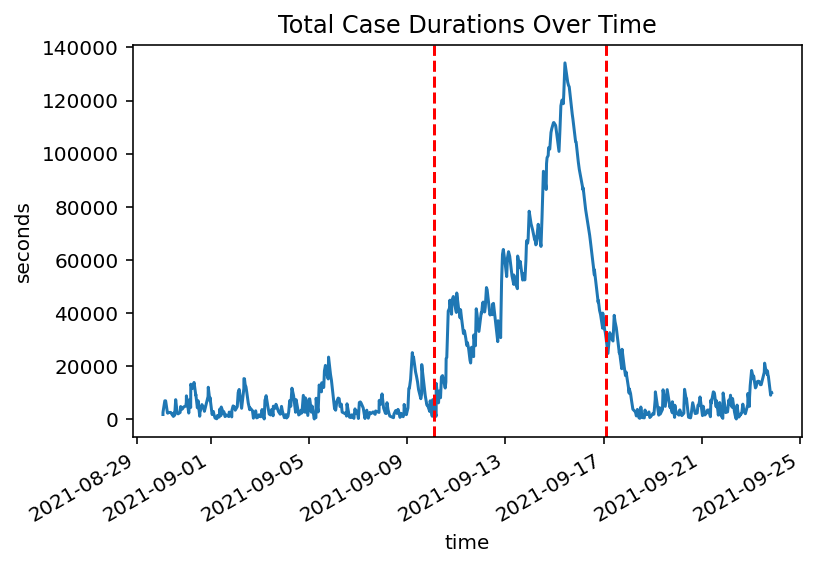

In [17]:
vizz(log)
mark_change_region()
plt.title('Total Case Durations Over Time')
plt.ylabel('seconds')
plt.xlabel('time')
plt.gcf().autofmt_xdate()
plt.savefig('whatif', dpi=300, bbox_inches="tight")

In [32]:
original_replay_result = repl.replay_log(original_log, net)
replay_result = repl.replay_log(log, net)

In [33]:
original_df = original_replay_result.trace_tracker.measurements_df
original_df

case_id activity resource                   enabled  \
0       default_case_0        A   System 2021-04-17 15:05:00+02:00   
1       default_case_0        C       R2 2021-04-17 15:05:00+02:00   
2       default_case_0        B       R1 2021-04-17 15:05:00+02:00   
3       default_case_1        A   System 2021-04-17 15:37:00+02:00   
4       default_case_1        B       R1 2021-04-17 15:37:00+02:00   
...                ...      ...      ...                       ...   
2995  default_case_998        C       R2 2021-05-29 03:38:00+02:00   
2996  default_case_998        B       R1 2021-05-29 03:38:00+02:00   
2997  default_case_999        A   System 2021-05-29 04:27:00+02:00   
2998  default_case_999        B       R1 2021-05-29 04:27:00+02:00   
2999  default_case_999        C       R2 2021-05-29 04:27:00+02:00   

                     completed           total delay  wait service  \
0    2021-04-17 15:05:00+02:00 0 days 00:00:00  None  None    None   
1    2021-04-17 15:06:00+02:00 0 days 00:01:00  None  None    None   
2    2021-04-17 15:08:00+02:00 0 days 00:03:00  None  None    None   
3    2021-04-17 15:37:00+02:00 0 days 00:00:00  None  None    None   
4    2021-04-17 15:43:00+02:00 0 days 00:06:00  None  None    None   
...                        ...             ...   ...   ...     ...   
2995 2021-05-29 04:30:00+02:00 0 days 00:52:00  None  None    None   
2996 2021-05-29 04:32:00+02:00 0 days 00:54:00  None  None    None   
2997 2021-05-29 04:27:00+02:00 0 days 00:00:00  None  None    None   
2998 2021-05-29 04:33:00+02:00 0 days 00:06:00  None  None    None   
2999 2021-05-29 04:53:00+02:00 0 days 00:26:00  None  None    None   

      total_seconds  concurrent_by_activity  concurrent_by_resource  \
0               0.0                       0                       0   
1              60.0                       0                       0   
2             180.0                       0                       0   
3               0.0                       0                       0   
4             360.0                       0                       0   
...             ...                     ...                     ...   
2995         3120.0                       1                       1   
2996         3240.0                       1                       1   
2997            0.0                       0                       0   
2998          360.0                       0                       0   
2999         1560.0                       0                       0   

      concurrent_by_combination  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  
...                         ...  
2995                          1  
2996                          1  
2997                          0  
2998                          0  
2999                          0  

[3000 rows x 13 columns]

In [34]:
df = replay_result.trace_tracker.measurements_df
df

case_id activity resource                   enabled  \
0       default_case_0        A   System 2021-08-30 00:03:00+02:00   
1       default_case_0        B       R1 2021-08-30 00:03:00+02:00   
2       default_case_0        C       R2 2021-08-30 00:03:00+02:00   
3       default_case_1        A   System 2021-08-30 01:34:00+02:00   
4       default_case_1        B       R1 2021-08-30 01:34:00+02:00   
...                ...      ...      ...                       ...   
1792  default_case_597        C       R2 2021-09-23 21:32:00+02:00   
1793  default_case_597        B       R1 2021-09-23 21:32:00+02:00   
1794  default_case_598        A   System 2021-09-23 23:07:00+02:00   
1795  default_case_598        B       R1 2021-09-23 23:07:00+02:00   
1796  default_case_598        C       R2 2021-09-23 23:07:00+02:00   

                     completed           total delay  wait service  \
0    2021-08-30 00:03:00+02:00 0 days 00:00:00  None  None    None   
1    2021-08-30 00:10:00+02:00 0 days 00:07:00  None  None    None   
2    2021-08-30 00:12:00+02:00 0 days 00:09:00  None  None    None   
3    2021-08-30 01:34:00+02:00 0 days 00:00:00  None  None    None   
4    2021-08-30 01:37:00+02:00 0 days 00:03:00  None  None    None   
...                        ...             ...   ...   ...     ...   
1792 2021-09-23 22:04:00+02:00 0 days 00:32:00  None  None    None   
1793 2021-09-23 22:59:00+02:00 0 days 01:27:00  None  None    None   
1794 2021-09-23 23:07:00+02:00 0 days 00:00:00  None  None    None   
1795 2021-09-23 23:38:00+02:00 0 days 00:31:00  None  None    None   
1796 2021-09-23 23:46:00+02:00 0 days 00:39:00  None  None    None   

      total_seconds  concurrent_by_activity  concurrent_by_resource  \
0               0.0                       0                       0   
1             420.0                       0                       0   
2             540.0                       0                       0   
3               0.0                       0                       0   
4             180.0                       0                       0   
...             ...                     ...                     ...   
1792         1920.0                       0                       0   
1793         5220.0                       0                       0   
1794            0.0                       0                       0   
1795         1860.0                       0                       0   
1796         2340.0                       0                       0   

      concurrent_by_combination  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  
...                         ...  
1792                          0  
1793                          0  
1794                          0  
1795                          0  
1796                          0  

[1797 rows x 13 columns]

<AxesSubplot:xlabel='completed', ylabel='total_seconds'>

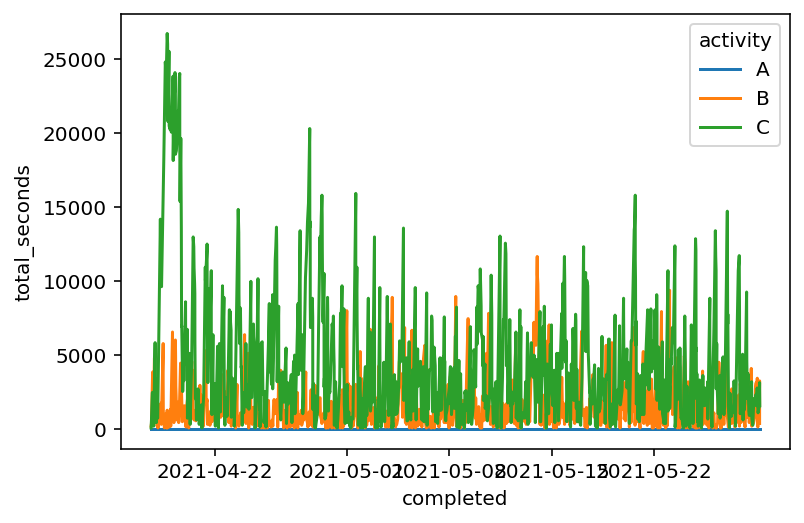

In [35]:
sns.lineplot(data=original_df, x='completed', y='total_seconds', hue='activity')

In [36]:
sns.lineplot(data=df, x='completed', y='total_seconds', hue='activity')
mark_change_region()